# Imports

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, Conv2D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow import keras
from keras.layers import Input, Flatten

# Data Generator

In [2]:
class dataCreator:
    def __init__(self,basePath,subPath) -> None:
        self.basePath = basePath
        self.subPath = subPath
        self.subset = []
        print(self.basePath,self.subPath)

    def listAppend(self):
        classes = os.listdir(self.basePath+self.subPath)
        # print(classes)

        classCounter = 0
        for i in classes:
            imagePaths = os.listdir(self.basePath+self.subPath+f'/{i}')
            temp = []
            for image in imagePaths:
                temp.append([f"{classCounter}",self.basePath+self.subPath+f'/{i}'+f'/{image}'])

            classCounter+=1
            # print(temp)
            self.subset += temp
    
    def shuffler(self):
        np.random.seed(0)
        npsubSet = np.array(self.subset)
        np.random.shuffle(npsubSet)
        return npsubSet

In [3]:
os.remove('/Volumes/Windows/BreastCancerDataset/Converted/Testing/.DS_Store')

In [4]:
datagen = dataCreator('/Volumes/Windows/BreastCancerDataset/Converted','/Training')
datagen.listAppend()
trainData = datagen.shuffler()

/Volumes/Windows/BreastCancerDataset/Converted /Training


In [5]:
datagen = dataCreator('/Volumes/Windows/BreastCancerDataset/Converted','/Testing')
datagen.listAppend()
testData = datagen.shuffler()

/Volumes/Windows/BreastCancerDataset/Converted /Testing


In [6]:
print(len(trainData),len(testData))

2939 356


# Feature Extractor

In [7]:
class FeatureExtractor:
    def __init__(self,dataset) -> None:
        self.base_model = tf.keras.applications.VGG19(input_shape=(150,150,3),
                                               include_top=False,
                                               weights='imagenet')
        self.dataset = dataset       
        self.extractedFeatures = []    
        self.labels = []            
        print(len(dataset))                     
                                                       
    def preProcessor(self,path):
        img = cv2.imread(path)
        img = cv2.resize(img,(150,150))
        imgx = np.expand_dims(img, axis=0)
        return imgx                                        
    
    def featureExtractor(self,path):
        feature = self.base_model(self.preProcessor(path))
        flattened = Flatten()(feature)
        # print(feature.shape,flattened.shape)
        return flattened

    def featureArrayCreator(self):
        for i in self.dataset:
            if i[1].split(".")[1]=="png":
                feature = self.featureExtractor(i[1])
                self.extractedFeatures.append(feature.numpy())
                self.labels.append(int(i[0]))    
        return [np.array(self.labels),np.array(self.extractedFeatures)]        
        

In [8]:
# print(len(trainData))
featureCreator = FeatureExtractor(trainData)
ytrain,Xtrain = featureCreator.featureArrayCreator()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-01-23 21:29:31.669179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-23 21:29:31.669326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2939


In [9]:
featureCreator = FeatureExtractor(testData)
ytest,Xtest = featureCreator.featureArrayCreator()

356


In [10]:
print(len(Xtrain),len(Xtest))

2936 352


In [11]:
Xtrain[:,0,:].shape

(2936, 8192)

# Predictions

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500)
clf.fit(Xtrain[:,0,:],ytrain)

RandomForestClassifier(n_estimators=500)

In [105]:
import xgboost as xgb
xg_cls = xgb.XGBClassifier()
xg_cls.fit(Xtrain[:,0,:],ytrain)

/Users/anishpawar/miniforge3/envs/tfnew/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:43:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [13]:
# from sklearn import metrics

score=0

for i in range(len(Xtest)):

    pred = clf.predict([Xtest[i,0]])

    if pred[0]==ytest[i]:
        score+=1
    print(pred[0],ytest[i])

    


1 0
1 1
0 3
2 2
1 1
2 2
3 1
1 0
0 0
3 3
1 0
1 3
2 2
3 3
1 1
2 2
1 1
0 0
1 1
2 2
3 3
2 0
2 2
2 2
3 1
0 0
0 0
0 0
1 1
0 3
2 1
1 0
0 0
1 0
3 3
2 2
2 1
2 2
1 1
0 0
2 2
2 2
2 2
2 2
0 3
1 1
0 0
0 0
1 1
3 3
2 2
2 2
2 2
2 0
2 0
2 2
2 1
2 2
3 2
1 0
2 1
2 1
0 0
2 1
2 2
2 2
1 1
1 1
2 2
0 0
3 3
2 2
2 3
1 3
1 1
0 0
3 3
1 1
0 0
3 3
3 3
3 3
2 2
2 2
1 1
0 0
2 1
1 1
1 1
1 1
2 0
2 2
0 0
1 1
2 1
2 3
2 3
0 0
2 2
3 3
3 3
2 2
1 3
1 1
2 1
2 2
1 3
1 1
2 1
3 3
1 1
2 2
1 0
2 0
1 1
0 0
2 2
2 2
0 1
3 3
2 1
2 2
1 3
2 2
2 2
2 0
0 0
3 3
0 0
2 1
2 1
2 0
3 3
3 3
1 3
2 2
2 1
1 1
2 0
3 3
1 1
0 0
1 1
3 3
3 3
2 3
1 0
2 2
2 2
0 3
1 3
2 0
2 2
1 1
3 3
1 1
0 3
3 3
2 2
3 3
0 0
2 2
2 2
2 2
2 2
0 0
2 2
1 1
1 1
1 1
1 1
2 2
2 2
0 0
2 2
1 0
3 3
0 0
2 2
0 3
3 3
2 2
2 1
2 2
3 1
0 0
2 3
1 1
2 2
2 2
0 3
1 1
2 1
1 1
3 1
0 0
2 2
3 0
1 1
3 3
1 3
1 1
3 3
2 0
2 1
2 2
0 0
0 0
2 3
1 1
2 2
1 3
2 2
3 3
1 0
1 1
2 0
1 1
3 3
0 0
2 2
1 1
0 0
2 0
0 0
2 2
2 2
3 3
2 3
2 2
0 0
3 3
2 3
2 2
3 3
2 0
1 0
0 0
0 0
1 1
2 2
0 0
0 0
2 3
0 0
1 0
0 0
2 1
0 0
1 2


In [110]:
score

29

In [14]:
print("Accuracy:{}".format(score/len(Xtest)))

Accuracy:0.6732954545454546


# Ignore

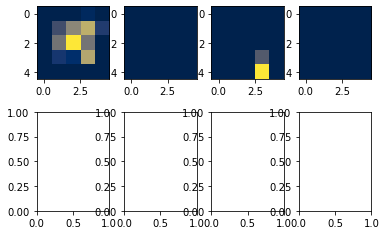

In [61]:
fig,ax = plt.subplots(2,4)

for i in range(0,4):
    fig1 = feature.numpy()[0,:,:,i]
    ax[0,i].imshow(fig1,cmap='cividis')
    # print(i%8,i%4)

(1536, 2048, 3)
(1, 150, 150, 3)


2022-01-22 17:18:44.132638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)
(1536, 2048, 3)
(1, 150, 150, 3)


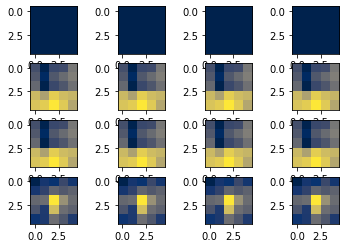

In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

fig,ax = plt.subplots(4,4)
IMG_1 = 0
IMG_2 = 3
IMG_3 = 100
IMG_4 = 7

CONVOLUTION_NUMBER = 1
layer_outputs = [layer.output for layer in base_model.layers]

# print(len(layer_outputs))
# Creating Activation Model using inputs and Outputs of original model
activation_model = keras.models.Model(inputs=base_model.input,outputs=layer_outputs)

# Displaying Convolutions
# Because there are 2 Convolution layers and 2 Max Pooling layers
for x in range(0,4):
  fig_1 = activation_model.predict(preProcessor('/Volumes/MacOS/NRL_Microscopic/Breast_Cancer/ICIAR2018_BACH_Challenge/Photos/Converted/Benign/b001.png'))[-1]
  ax[0,x].imshow(fig_1[0,:,:,4],cmap='cividis')
  
  fig_2 = activation_model.predict(preProcessor('/Volumes/MacOS/NRL_Microscopic/Breast_Cancer/ICIAR2018_BACH_Challenge/Photos/Converted/Benign/b001.png'))[-2]
  ax[1,x].imshow(fig_2[0,:,:,4],cmap='cividis')
  
  fig_3 = activation_model.predict(preProcessor('/Volumes/MacOS/NRL_Microscopic/Breast_Cancer/ICIAR2018_BACH_Challenge/Photos/Converted/Benign/b001.png'))[-3]
  ax[2,x].imshow(fig_3[0,:,:,4],cmap='cividis')
  
  fig_4 = activation_model.predict(preProcessor('/Volumes/MacOS/NRL_Microscopic/Breast_Cancer/ICIAR2018_BACH_Challenge/Photos/Converted/Benign/b001.png'))[-4]
  ax[3,x].imshow(fig_4[0,:,:,4],cmap='cividis')

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

fig,ax = plt.subplots(4,4)
IMG_1 = 0
IMG_2 = 3
IMG_3 = 100
IMG_4 = 7

CONVOLUTION_NUMBER = 1
layer_outputs = [layer.output for layer in base_model.layers]

# Creating Activation Model using inputs and Outputs of original model
activation_model = keras.models.Model(inputs=base_model.input,outputs=layer_outputs)

# Displaying Convolutions
# Because there are 2 Convolution layers and 2 Max Pooling layers
for x in range(0,4):
  fig_1 = activation_model.predict(test_images[IMG_1].reshape(1,28,28,1))[x]
  ax[0,x].imshow(fig_1[0,:,:,CONVOLUTION_NUMBER],cmap='cividis')
  
  fig_2 = activation_model.predict(test_images[IMG_2].reshape(1,28,28,1))[x]
  ax[1,x].imshow(fig_2[0,:,:,CONVOLUTION_NUMBER],cmap='cividis')
  
  fig_3 = activation_model.predict(test_images[IMG_3].reshape(1,28,28,1))[x]
  ax[2,x].imshow(fig_3[0,:,:,CONVOLUTION_NUMBER],cmap='cividis')
  
  fig_4 = activation_model.predict(test_images[IMG_4].reshape(1,28,28,1))[x]
  ax[3,x].imshow(fig_4[0,:,:,CONVOLUTION_NUMBER],cmap='cividis')